In [1]:
# Edgar data Aug 2023
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import pathlib
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from models import *
from utils import *

from loguru import logger
from sklearn.linear_model import TweedieRegressor
from preprocessing import *

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

NVIDIA GeForce GTX TITAN X


In [2]:
parent_path = Path('./data/biological/')
stim_path = parent_path / "AUG23/"
save_path = Path('./save/trained_models/AUG23/')

area_ID_ephys = np.load(stim_path / 'area_idx.npy')        # (106,) 8 LS, 70 ACC
dff_stim = np.load(stim_path /'img_array.npy')                  # (189, 19010) GCaMP when stimulated 
spks_stim_1hz = np.load(stim_path /'ephys_array.npy')                # (92, 536020)

dff_stim_times_a = np.load(stim_path / 'img_stim_a.npy').reshape(-1,1)
ephys_stim_times_a = np.load(stim_path / 'ephys_stim_a.npy').reshape(-1,1)
ephys_stim_times_b = np.load(stim_path / 'ephys_stim_b.npy').reshape(-1,1)


### Preprocessing

#### Alignment

In [3]:
# align stim instances with stim_a
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(dff_stim_times_a, ephys_stim_times_a) # ephys at 1Hz, dff at 30 Hz. 
bin_size = lr.coef_.flatten() # bin size
ephys_offset = lr.intercept_ # y-intercept

# ephys_time = 7478 + 33.29 * dff 
# i.e. dFF = 0, Ephys= 7478 needs to shift Ephys back by 7874
# check error

assert np.sum(np.round((ephys_stim_times_a.T - ephys_offset) / bin_size) - dff_stim_times_a.T) < 1

spks_stim_shifted = spks_stim_1hz[:, int(ephys_offset):]
from utils import bin_spikes
spks_stim = bin_spikes(spks_stim_shifted, bin_size)
stim_time = np.round((np.array(sorted(list(set(list(ephys_stim_times_a.T[0]) + list(ephys_stim_times_b.T[0]))))) - ephys_offset) / bin_size)

/tmp/ipykernel_65679/957492132.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  spks_stim_shifted = spks_stim_1hz[:, int(ephys_offset):]


#### Convolve spikes

2024-03-21 12:43:15.936 | INFO     | preprocessing:convolve_spikes:26 - Detected Ephys file with 92 neurons and 15872 bins.
2024-03-21 12:43:16.020 | INFO     | preprocessing:convolve_spikes:51 - Produced convolved rates at sigma=0.1 with 92 neurons and 15872 bins.


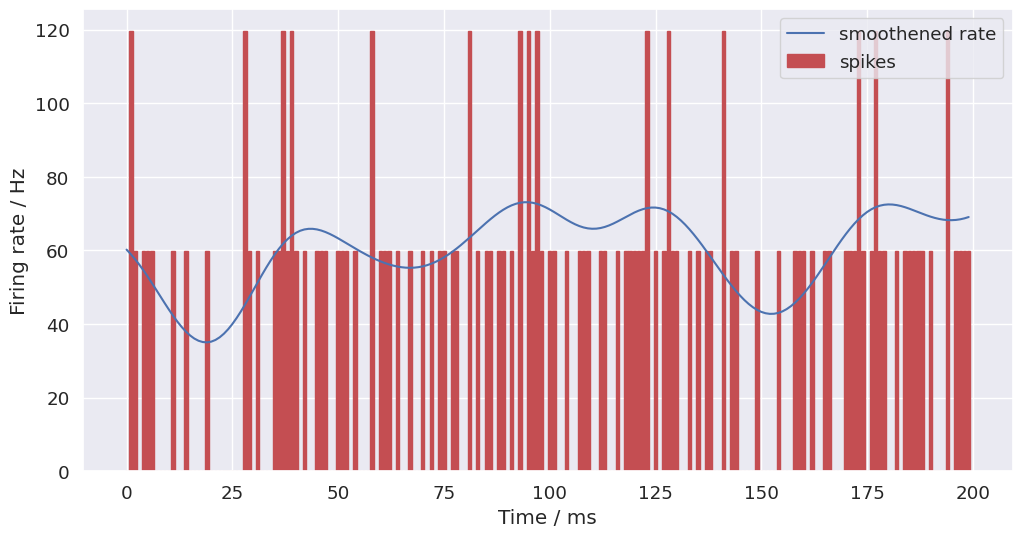

In [4]:
spks_stim_rates, n_output_neurons, n_bins = convolve_spikes(spks_stim)
plot_convolution_example(spks_stim_rates, spks_stim,seed=seed)
input_dim = dff_stim.shape[0]
# assert n_bins == dff_stim.shape[1]
# asertion error: truncate dff_stim
dff_stim = dff_stim[:, :n_bins]
stim_time = stim_time[stim_time < n_bins]

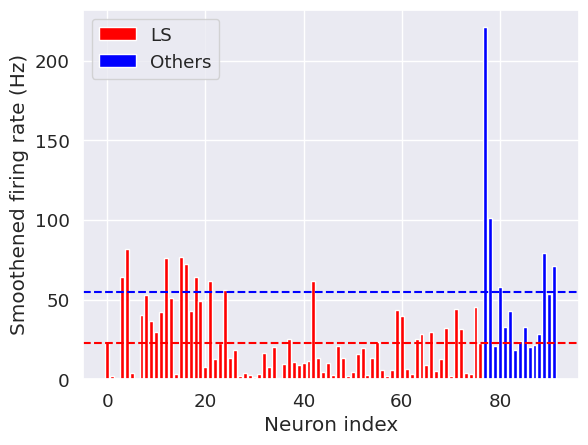

LS neuron firing rate: 22.714384078979492 Hz
non-LS neuron firing rate: 55.002647399902344 Hz


In [5]:
mask1 = area_ID_ephys == 'LS'
mask2 = area_ID_ephys != 'LS'

plt.bar(np.arange(spks_stim_rates.shape[1])[mask1], spks_stim_rates.mean(0)[mask1], color='red', label='LS')
plt.bar(np.arange(spks_stim_rates.shape[1])[mask2], spks_stim_rates.mean(0)[mask2], color='blue', label='Others')
plt.axhline(spks_stim_rates.mean(0)[mask1].mean(), linestyle='--', color='red')
plt.axhline(spks_stim_rates.mean(0)[mask2].mean(), linestyle='--', color='blue')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Smoothened firing rate (Hz)')
plt.show()
print(f'LS neuron firing rate: {spks_stim_rates.mean(0)[mask1].mean()} Hz')
print(f'non-LS neuron firing rate: {spks_stim_rates.mean(0)[mask2].mean()} Hz')

#### Extract Stim instances

In [6]:
stim_ID = ['D' for _ in range(len(stim_time))] # dummy stim_ID
inputs, targets, non_stim_vecs_idx, stim_vecs_idx = preprocess_dff_rate_pairs(dff_stim, spks_stim_rates, has_stim=True, stim_time=stim_time, stim_ID=stim_ID, cutoff_size=1, offset=-3, tsteps=15)
sampled_non_stim_vecs = sample_non_stim_vecs(non_stim_vecs_idx, cutoff_size=1, n=200, seed=seed)
test_set_idx = np.concatenate([stim_vecs_idx, sampled_non_stim_vecs])
X_train, Y_train = inputs[non_stim_vecs_idx], targets[non_stim_vecs_idx]
X_test, Y_test = inputs[test_set_idx], targets[test_set_idx]

### Training

### LS Neurons

In [7]:
LS_neuron_idx = np.where(area_ID_ephys == 'LS')[0]
ACC_neuron_idx = np.where(area_ID_ephys == 'ACC')[0]
Others_neuron_idx = np.where(area_ID_ephys == 'Other')[0]
nLS_neuron_idx = np.where(area_ID_ephys != 'LS')[0]

# randomise valid idx
n_non_stim = len(Y_train)
valid_idx = np.random.choice(np.arange(len(Y_train)), int(n_non_stim * 0.10))
train_idx = np.array(list((set(np.arange(len(Y_train))) - set(valid_idx))))

stim_ID = ['D' for _ in range(len(stim_time))]
forward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'F')[0])
backward_mse_idx = list(np.nonzero(np.array(stim_ID) == 'R')[0])
random_mse_idx = list(np.nonzero(np.array(stim_ID) == 'S')[0])
non_stim_mse_idx = np.arange(len(stim_ID), Y_test.shape[0])

In [8]:
# 8 neurons are lateral septal according to Edgar
Y_train_LS = Y_train[train_idx,:,:][..., LS_neuron_idx]
Y_test_LS = Y_test[..., LS_neuron_idx]
Y_valid_LS = Y_train[valid_idx,:,:][..., LS_neuron_idx]

output_dim = len(LS_neuron_idx)

batch_size = 1024
train_dataset = BNN_Dataset(X_train[train_idx, ...], Y_train_LS)
train_dataloader_LS = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
test_dataset = BNN_Dataset(X_test, Y_test_LS)
test_dataloader_LS = DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=False, shuffle=False)
valid_dataset = BNN_Dataset(X_train[valid_idx, ...], Y_valid_LS)
valid_dataloader_LS = DataLoader(valid_dataset, batch_size=len(valid_dataset), drop_last=False, shuffle=False)
del train_dataset, test_dataset, valid_dataset

# fit GLM with identity link function
X_train_np = X_train[train_idx, ...].cpu().numpy().reshape(X_train[train_idx, ...].shape[0],-1)
Y_train_LS_np = Y_train_LS.cpu().numpy().reshape(Y_train_LS.shape[0],-1) + 1e-6 # numerical stability

X_test_np = X_test.cpu().numpy().reshape(X_test.shape[0],-1)
Y_test_LS_np = Y_test_LS.cpu().numpy().reshape(Y_test_LS.shape[0],-1) + 1e-6 # numerical stability

#### Bayes Opt

In [48]:
_run = True
from bayes_opt import BayesianOptimization
from models import TransformerOneStep
from train import train_transformer, eval_transformer
from utils import count_parameters

LS_param_counts = []

import gc
def black_box_function(d_model, num_heads, hidden_dim, n_layers, seed=seed):
    gc.collect()
    torch.cuda.empty_cache()
    
    seed = 123
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    hidden_dim, d_model, n_layers, num_heads = int(hidden_dim), int(d_model), int(n_layers), int(num_heads)
    d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
    if d_model %2 != 0:
        d_model += num_heads
        
    DNN = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                use_mask=False,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)
    
    optimiser = torch.optim.Adam(DNN.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=10, threshold=0.01)

    return_dict = train_transformer(
        model=DNN,
        train_loader=train_dataloader_LS, test_loader=valid_dataloader_LS, # use valid loader here
        optimiser=optimiser, criterion=criterion, num_epochs=250,
        verbose=False, force_stop=False, scheduler=scheduler)

    LS_param_counts.append([min(return_dict['eval_losses']), count_parameters(DNN), d_model, num_heads, hidden_dim, n_layers])
    valid_loss = -min(return_dict['eval_losses'])   
    del DNN, return_dict
    gc.collect()
    torch.cuda.empty_cache()
    return valid_loss

def run_bayes_opt(pbounds, init_points=100, n_iter=100):
    optimizer = BayesianOptimization(f=black_box_function, pbounds=pbounds, random_state=123)
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

if _run:
    run_bayes_opt(pbounds = {'d_model':(100, 2000), 'num_heads':(1, 30), 'hidden_dim':(100, 1000), 'n_layers':(1, 5)}, init_points=200, n_iter=200)
    np.save(f'./data/trained_models/AUG23-stim-LS-param_counts.npy', np.array(LS_param_counts))

|   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
-------------------------------------------------------------------------


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 76%|███████▌  | 189/250 [00:25<00:08,  7.42it/s]


| 1         | -209.1    | 1.423e+03 | 357.5     | 1.907     | 16.99     |


 66%|██████▋   | 166/250 [01:42<00:51,  1.62it/s]


| 2         | -268.5    | 1.467e+03 | 480.8     | 4.923     | 20.86     |


 76%|███████▋  | 191/250 [00:36<00:11,  5.18it/s]


| 3         | -268.1    | 1.014e+03 | 452.9     | 2.373     | 22.14     |


 76%|███████▌  | 189/250 [00:31<00:10,  5.91it/s]


| 4         | -267.5    | 933.3     | 153.7     | 2.592     | 22.4      |


100%|██████████| 250/250 [00:26<00:00,  9.47it/s]


| 5         | -238.3    | 446.7     | 257.9     | 3.126     | 16.42     |


 69%|██████▉   | 172/250 [01:14<00:33,  2.31it/s]


| 6         | -268.2    | 1.305e+03 | 864.5     | 3.898     | 18.72     |


 67%|██████▋   | 167/250 [00:55<00:27,  3.03it/s]


| 7         | -268.2    | 1.473e+03 | 390.7     | 2.447     | 7.62      |


 92%|█████████▏| 231/250 [00:15<00:01, 14.79it/s]


| 8         | -229.4    | 658.1     | 667.9     | 1.368     | 13.58     |


 77%|███████▋  | 192/250 [00:34<00:10,  5.54it/s]


| 9         | -268.7    | 918.6     | 544.3     | 2.703     | 10.06     |


 77%|███████▋  | 193/250 [01:08<00:20,  2.82it/s]


| 10        | -266.6    | 910.1     | 904.1     | 4.777     | 15.55     |


 71%|███████   | 178/250 [00:47<00:19,  3.75it/s]


| 11        | -268.6    | 1.286e+03 | 204.1     | 2.269     | 13.03     |


 64%|██████▍   | 161/250 [01:11<00:39,  2.24it/s]


| 12        | -269.0    | 1.746e+03 | 325.4     | 2.932     | 29.58     |


 82%|████████▏ | 204/250 [00:24<00:05,  8.43it/s]


| 13        | -221.8    | 1.087e+03 | 651.6     | 1.483     | 24.96     |


 70%|██████▉   | 174/250 [00:43<00:18,  4.04it/s]


| 14        | -268.1    | 1.246e+03 | 590.6     | 2.371     | 9.82      |


 77%|███████▋  | 193/250 [01:03<00:18,  3.02it/s]


| 15        | -267.7    | 892.3     | 713.2     | 4.502     | 15.8      |


 69%|██████▉   | 172/250 [01:11<00:32,  2.39it/s]


| 16        | -268.2    | 1.372e+03 | 627.3     | 3.5       | 20.57     |


 65%|██████▌   | 163/250 [01:51<00:59,  1.46it/s]


| 17        | -269.0    | 1.7e+03   | 174.9     | 4.055     | 8.066     |


 95%|█████████▍| 237/250 [00:13<00:00, 17.39it/s]


| 18        | -244.6    | 469.0     | 615.2     | 1.383     | 26.67     |


 78%|███████▊  | 194/250 [00:30<00:08,  6.44it/s]


| 19        | -220.9    | 1.292e+03 | 751.1     | 1.065     | 18.24     |


 88%|████████▊ | 219/250 [00:24<00:03,  8.81it/s]


| 20        | -217.2    | 1.158e+03 | 243.1     | 1.612     | 21.17     |


 87%|████████▋ | 218/250 [00:39<00:05,  5.56it/s]


| 21        | -266.7    | 705.7     | 722.8     | 3.218     | 12.28     |


 64%|██████▍   | 161/250 [01:11<00:39,  2.26it/s]


| 22        | -268.9    | 1.858e+03 | 857.5     | 2.43      | 2.264     |


 88%|████████▊ | 220/250 [00:44<00:06,  4.93it/s]


| 23        | -266.8    | 679.1     | 458.4     | 3.82      | 29.87     |


 86%|████████▌ | 215/250 [00:45<00:07,  4.68it/s]


| 24        | -266.7    | 776.2     | 786.3     | 3.373     | 21.06     |


100%|██████████| 250/250 [00:08<00:00, 28.15it/s]


| 25        | -240.2    | 387.1     | 459.0     | 1.963     | 10.96     |


 88%|████████▊ | 219/250 [00:23<00:03,  9.48it/s]


| 26        | -227.7    | 1.075e+03 | 700.0     | 1.424     | 4.796     |


 85%|████████▍ | 212/250 [00:55<00:10,  3.79it/s]


| 27        | -267.6    | 711.8     | 695.4     | 4.386     | 17.04     |


 64%|██████▎   | 159/250 [01:04<00:36,  2.48it/s]


| 28        | -268.8    | 1.723e+03 | 446.4     | 2.267     | 11.27     |


100%|██████████| 250/250 [00:24<00:00, 10.31it/s]


| 29        | -233.3    | 425.1     | 846.2     | 2.355     | 17.02     |


 80%|████████  | 200/250 [00:28<00:07,  6.98it/s]


| 30        | -218.5    | 1.199e+03 | 569.4     | 1.011     | 29.66     |


 64%|██████▍   | 161/250 [01:07<00:37,  2.39it/s]


| 31        | -269.4    | 1.82e+03  | 286.9     | 2.17      | 16.08     |


 63%|██████▎   | 157/250 [01:16<00:45,  2.05it/s]


| 32        | -268.7    | 1.814e+03 | 985.3     | 2.03      | 17.37     |


 64%|██████▍   | 160/250 [01:25<00:47,  1.88it/s]


| 33        | -268.5    | 1.633e+03 | 454.9     | 3.924     | 5.671     |


 69%|██████▉   | 173/250 [01:27<00:38,  1.99it/s]


| 34        | -268.1    | 1.241e+03 | 879.3     | 4.934     | 3.302     |


 79%|███████▉  | 198/250 [00:32<00:08,  6.09it/s]


| 35        | -266.6    | 913.9     | 284.1     | 2.803     | 16.89     |


100%|██████████| 250/250 [00:26<00:00,  9.60it/s]


| 36        | -253.0    | 277.3     | 367.2     | 4.71      | 17.5      |


 78%|███████▊  | 194/250 [00:48<00:13,  4.00it/s]


| 37        | -267.9    | 969.1     | 778.2     | 3.967     | 2.409     |


 76%|███████▌  | 190/250 [00:35<00:11,  5.39it/s]


| 38        | -211.6    | 1.447e+03 | 855.3     | 1.664     | 23.65     |


 91%|█████████ | 227/250 [00:31<00:03,  7.19it/s]


| 39        | -264.4    | 644.4     | 375.8     | 3.661     | 4.23      |


 68%|██████▊   | 171/250 [01:17<00:35,  2.20it/s]


| 40        | -268.3    | 1.363e+03 | 899.1     | 3.785     | 13.77     |


 80%|████████  | 200/250 [00:54<00:13,  3.70it/s]


| 41        | -267.3    | 932.6     | 788.6     | 3.263     | 3.462     |


 71%|███████   | 177/250 [00:51<00:21,  3.41it/s]


| 42        | -268.1    | 1.207e+03 | 833.4     | 2.348     | 27.9      |


 66%|██████▌   | 165/250 [01:46<00:55,  1.54it/s]


| 43        | -268.5    | 1.526e+03 | 616.7     | 4.007     | 3.295     |


 67%|██████▋   | 168/250 [02:13<01:05,  1.25it/s]


| 44        | -267.7    | 1.733e+03 | 839.4     | 4.639     | 4.73      |


100%|██████████| 250/250 [00:14<00:00, 17.50it/s]


| 45        | -258.8    | 255.4     | 224.6     | 2.598     | 13.3      |


 78%|███████▊  | 196/250 [00:23<00:06,  8.52it/s]


| 46        | -226.1    | 1.168e+03 | 210.0     | 1.806     | 24.54     |


 85%|████████▌ | 213/250 [00:22<00:03,  9.59it/s]


| 47        | -217.2    | 989.2     | 827.1     | 1.03      | 17.0      |


 73%|███████▎  | 183/250 [00:48<00:17,  3.80it/s]


| 48        | -209.8    | 1.871e+03 | 624.0     | 1.824     | 21.81     |


 90%|████████▉ | 224/250 [00:19<00:02, 11.37it/s]


| 49        | -222.2    | 820.1     | 701.5     | 1.117     | 19.44     |


100%|██████████| 250/250 [00:10<00:00, 24.72it/s]


| 50        | -292.7    | 161.2     | 770.3     | 2.892     | 4.531     |


 73%|███████▎  | 182/250 [01:03<00:23,  2.88it/s]


| 51        | -267.7    | 1.131e+03 | 160.1     | 3.613     | 29.89     |


 75%|███████▌  | 188/250 [00:40<00:13,  4.62it/s]


| 52        | -211.9    | 1.562e+03 | 616.4     | 1.411     | 21.3      |


 72%|███████▏  | 180/250 [01:30<00:35,  1.98it/s]


| 53        | -267.6    | 1.356e+03 | 144.2     | 4.169     | 16.04     |


 81%|████████  | 203/250 [00:35<00:08,  5.67it/s]


| 54        | -264.6    | 909.1     | 809.4     | 2.646     | 14.95     |


100%|██████████| 250/250 [00:31<00:00,  7.87it/s]


| 55        | -234.4    | 445.1     | 389.2     | 4.382     | 6.42      |


 82%|████████▏ | 205/250 [00:23<00:05,  8.69it/s]


| 56        | -228.5    | 892.9     | 990.1     | 1.946     | 27.59     |


 70%|███████   | 176/250 [01:24<00:35,  2.09it/s]


| 57        | -248.4    | 1.845e+03 | 182.2     | 2.855     | 15.56     |


 95%|█████████▌| 238/250 [00:14<00:00, 16.97it/s]


| 58        | -227.2    | 696.0     | 142.6     | 1.967     | 3.77      |


 96%|█████████▋| 241/250 [00:44<00:01,  5.45it/s]


| 59        | -266.9    | 552.7     | 827.0     | 4.58      | 2.253     |


 82%|████████▏ | 206/250 [00:44<00:09,  4.63it/s]


| 60        | -262.2    | 673.7     | 982.5     | 3.158     | 19.16     |


100%|██████████| 250/250 [00:18<00:00, 13.42it/s]


| 61        | -359.8    | 110.5     | 536.4     | 4.953     | 11.88     |


100%|██████████| 250/250 [00:25<00:00,  9.91it/s]


| 62        | -247.4    | 284.4     | 515.7     | 4.852     | 10.91     |


 72%|███████▏  | 180/250 [00:36<00:14,  4.94it/s]


| 63        | -224.4    | 1.618e+03 | 819.0     | 1.833     | 13.86     |


 74%|███████▍  | 186/250 [00:30<00:10,  6.05it/s]


| 64        | -215.9    | 1.46e+03  | 469.5     | 1.764     | 29.06     |


 79%|███████▉  | 197/250 [00:29<00:07,  6.77it/s]


| 65        | -224.2    | 1.336e+03 | 878.9     | 1.101     | 8.74      |


 76%|███████▌  | 190/250 [01:04<00:20,  2.94it/s]


| 66        | -266.6    | 1.054e+03 | 160.7     | 4.972     | 7.857     |


 93%|█████████▎| 233/250 [00:16<00:01, 13.87it/s]


| 67        | -217.6    | 811.2     | 292.6     | 1.422     | 7.742     |


 98%|█████████▊| 245/250 [00:28<00:00,  8.54it/s]


| 68        | -221.5    | 671.2     | 671.0     | 2.125     | 11.51     |


100%|██████████| 250/250 [00:10<00:00, 23.30it/s]


| 69        | -393.9    | 111.3     | 429.1     | 3.136     | 5.698     |


 70%|██████▉   | 174/250 [00:59<00:25,  2.94it/s]


| 70        | -268.3    | 1.235e+03 | 363.8     | 3.528     | 1.76      |


 75%|███████▌  | 188/250 [00:39<00:13,  4.75it/s]


| 71        | -213.5    | 1.786e+03 | 114.5     | 1.508     | 23.54     |


100%|██████████| 250/250 [00:31<00:00,  7.97it/s]


| 72        | -267.8    | 187.2     | 739.9     | 4.884     | 26.28     |


 68%|██████▊   | 171/250 [00:57<00:26,  3.00it/s]


| 73        | -267.0    | 1.449e+03 | 962.7     | 2.719     | 26.31     |


 92%|█████████▏| 229/250 [00:19<00:01, 11.47it/s]


| 74        | -216.6    | 776.3     | 936.8     | 1.595     | 28.26     |


 73%|███████▎  | 182/250 [00:38<00:14,  4.68it/s]


| 75        | -210.9    | 1.682e+03 | 861.4     | 1.496     | 18.3      |


100%|██████████| 250/250 [00:05<00:00, 43.89it/s]


| 76        | -307.3    | 131.1     | 749.1     | 1.031     | 3.46      |


 95%|█████████▌| 238/250 [00:24<00:01,  9.63it/s]


| 77        | -230.8    | 528.4     | 887.6     | 2.454     | 16.66     |


 71%|███████   | 177/250 [00:56<00:23,  3.15it/s]


| 78        | -267.0    | 1.179e+03 | 302.9     | 3.289     | 20.17     |


 94%|█████████▍| 236/250 [00:30<00:01,  7.75it/s]


| 79        | -232.6    | 666.7     | 476.8     | 2.812     | 28.04     |


 74%|███████▎  | 184/250 [01:20<00:28,  2.29it/s]


| 80        | -268.0    | 1.216e+03 | 953.4     | 3.224     | 15.52     |


100%|██████████| 250/250 [00:14<00:00, 16.91it/s]


| 81        | -365.2    | 106.7     | 532.8     | 4.71      | 6.753     |


100%|██████████| 250/250 [00:15<00:00, 15.84it/s]


| 82        | -263.8    | 199.0     | 466.1     | 2.49      | 25.86     |


100%|██████████| 250/250 [00:24<00:00, 10.36it/s]


| 83        | -282.2    | 150.6     | 928.1     | 3.724     | 27.22     |


 69%|██████▉   | 172/250 [00:46<00:21,  3.67it/s]


| 84        | -268.1    | 1.254e+03 | 830.8     | 2.342     | 11.14     |


 81%|████████  | 202/250 [00:30<00:07,  6.66it/s]


| 85        | -264.4    | 840.8     | 779.3     | 2.477     | 8.024     |


 61%|██████    | 153/250 [01:18<00:49,  1.96it/s]


| 86        | -269.0    | 1.882e+03 | 917.2     | 2.395     | 19.4      |


 91%|█████████ | 228/250 [00:21<00:02, 10.75it/s]


| 87        | -234.4    | 620.3     | 285.5     | 2.345     | 10.49     |


 65%|██████▌   | 163/250 [01:48<00:57,  1.51it/s]


| 88        | -268.6    | 1.776e+03 | 840.1     | 3.838     | 28.82     |


 99%|█████████▉| 247/250 [00:20<00:00, 12.35it/s]


| 89        | -211.8    | 902.8     | 320.5     | 1.47      | 9.731     |


100%|██████████| 250/250 [00:19<00:00, 12.60it/s]


| 90        | -243.5    | 376.0     | 183.0     | 3.412     | 11.56     |


 72%|███████▏  | 181/250 [00:54<00:20,  3.34it/s]


| 91        | -268.4    | 1.173e+03 | 272.2     | 3.708     | 7.25      |


 97%|█████████▋| 242/250 [00:36<00:01,  6.60it/s]


| 92        | -235.8    | 628.2     | 767.6     | 3.239     | 10.71     |


 75%|███████▌  | 188/250 [01:25<00:28,  2.20it/s]


| 93        | -267.1    | 1.132e+03 | 724.6     | 4.649     | 17.84     |


100%|██████████| 250/250 [00:43<00:00,  5.81it/s]


| 94        | -249.0    | 542.1     | 772.0     | 4.111     | 6.812     |


 65%|██████▌   | 163/250 [01:59<01:03,  1.36it/s]


| 95        | -268.5    | 1.659e+03 | 518.4     | 4.119     | 7.887     |


 93%|█████████▎| 233/250 [00:50<00:03,  4.59it/s]


| 96        | -241.9    | 731.9     | 958.3     | 3.631     | 23.41     |


 73%|███████▎  | 182/250 [00:49<00:18,  3.69it/s]


| 97        | -263.0    | 1.408e+03 | 283.9     | 2.883     | 24.46     |


 79%|███████▉  | 198/250 [00:28<00:07,  6.89it/s]


| 98        | -217.9    | 1.383e+03 | 105.4     | 1.35      | 11.06     |


 65%|██████▍   | 162/250 [01:16<00:41,  2.13it/s]


| 99        | -268.6    | 1.894e+03 | 542.1     | 2.081     | 11.45     |


100%|██████████| 250/250 [00:14<00:00, 17.70it/s]


| 100       | -241.0    | 500.2     | 479.1     | 1.872     | 25.53     |


 78%|███████▊  | 196/250 [01:04<00:17,  3.04it/s]


| 101       | -266.6    | 966.9     | 351.8     | 4.732     | 10.12     |


 63%|██████▎   | 158/250 [01:50<01:04,  1.42it/s]


| 102       | -269.2    | 1.828e+03 | 139.1     | 3.828     | 15.03     |


 88%|████████▊ | 219/250 [00:18<00:02, 11.69it/s]


| 103       | -222.5    | 944.0     | 132.7     | 1.163     | 10.65     |


 66%|██████▌   | 164/250 [01:20<00:42,  2.03it/s]


| 104       | -268.9    | 1.9e+03   | 655.9     | 2.475     | 18.75     |


100%|██████████| 250/250 [00:23<00:00, 10.76it/s]


| 105       | -235.0    | 491.6     | 248.6     | 2.447     | 26.04     |


 76%|███████▋  | 191/250 [01:13<00:22,  2.62it/s]


| 106       | -267.0    | 1.068e+03 | 367.2     | 4.801     | 24.66     |


 85%|████████▍ | 212/250 [00:53<00:09,  3.93it/s]


| 107       | -266.8    | 713.7     | 974.9     | 4.949     | 12.85     |


 66%|██████▋   | 166/250 [00:40<00:20,  4.09it/s]


| 108       | -268.2    | 1.346e+03 | 465.1     | 2.029     | 3.397     |


 96%|█████████▋| 241/250 [00:21<00:00, 11.33it/s]


| 109       | -223.1    | 600.9     | 344.3     | 2.595     | 6.362     |


 64%|██████▎   | 159/250 [01:42<00:58,  1.54it/s]


| 110       | -268.3    | 1.912e+03 | 192.6     | 3.501     | 13.81     |


 80%|████████  | 200/250 [00:59<00:14,  3.39it/s]


| 111       | -265.9    | 904.7     | 434.8     | 4.473     | 9.134     |


100%|██████████| 250/250 [00:18<00:00, 13.41it/s]


| 112       | -297.2    | 139.1     | 926.3     | 4.458     | 9.03      |


 81%|████████  | 203/250 [00:22<00:05,  8.83it/s]


| 113       | -222.2    | 1.095e+03 | 198.2     | 1.374     | 25.29     |


 80%|████████  | 201/250 [01:01<00:14,  3.27it/s]


| 114       | -267.2    | 879.5     | 695.5     | 4.773     | 8.109     |


100%|██████████| 250/250 [00:20<00:00, 12.31it/s]


| 115       | -342.0    | 125.0     | 121.7     | 3.838     | 27.81     |


 77%|███████▋  | 192/250 [00:54<00:16,  3.52it/s]


| 116       | -266.4    | 987.9     | 437.6     | 3.171     | 25.91     |


 68%|██████▊   | 171/250 [01:19<00:36,  2.16it/s]


| 117       | -267.1    | 1.339e+03 | 309.7     | 4.098     | 4.904     |


100%|██████████| 250/250 [00:12<00:00, 19.56it/s]


| 118       | -238.6    | 414.6     | 651.4     | 1.955     | 21.44     |


 85%|████████▌ | 213/250 [00:43<00:07,  4.88it/s]


| 119       | -266.4    | 764.1     | 349.7     | 4.996     | 2.178     |


 69%|██████▉   | 172/250 [01:20<00:36,  2.14it/s]


| 120       | -268.5    | 1.327e+03 | 134.8     | 4.041     | 7.673     |


100%|██████████| 250/250 [00:24<00:00, 10.17it/s]


| 121       | -262.0    | 270.7     | 683.6     | 3.93      | 20.66     |


100%|██████████| 250/250 [00:10<00:00, 23.54it/s]


| 122       | -281.6    | 198.6     | 364.9     | 2.804     | 9.326     |


 66%|██████▌   | 165/250 [01:23<00:42,  1.98it/s]


| 123       | -268.9    | 1.64e+03  | 218.0     | 3.449     | 29.66     |


 72%|███████▏  | 181/250 [00:39<00:15,  4.55it/s]


| 124       | -215.3    | 1.815e+03 | 299.9     | 1.0       | 29.44     |


 62%|██████▏   | 156/250 [01:08<00:41,  2.28it/s]


| 125       | -268.8    | 1.777e+03 | 927.5     | 2.662     | 22.59     |


 98%|█████████▊| 244/250 [00:32<00:00,  7.52it/s]


| 126       | -246.5    | 504.4     | 453.1     | 4.406     | 4.701     |


 64%|██████▍   | 161/250 [01:07<00:37,  2.37it/s]


| 127       | -269.1    | 1.798e+03 | 546.9     | 2.704     | 9.864     |


 61%|██████    | 153/250 [02:18<01:27,  1.11it/s]


| 128       | -269.6    | 1.842e+03 | 565.9     | 4.216     | 25.87     |


 63%|██████▎   | 158/250 [01:05<00:38,  2.40it/s]


| 129       | -269.0    | 1.853e+03 | 373.0     | 2.359     | 18.26     |


 76%|███████▌  | 189/250 [00:37<00:12,  4.98it/s]


| 130       | -267.8    | 938.5     | 939.6     | 2.59      | 14.86     |


 69%|██████▉   | 173/250 [01:24<00:37,  2.04it/s]


| 131       | -268.0    | 1.273e+03 | 464.3     | 4.97      | 3.867     |


100%|██████████| 250/250 [00:11<00:00, 20.99it/s]


| 132       | -232.5    | 519.1     | 390.4     | 1.591     | 9.242     |


 76%|███████▌  | 190/250 [00:36<00:11,  5.20it/s]


| 133       | -216.1    | 1.581e+03 | 570.6     | 1.136     | 29.5      |


 71%|███████   | 178/250 [01:06<00:26,  2.67it/s]


| 134       | -267.1    | 1.27e+03  | 153.0     | 3.645     | 11.97     |


100%|██████████| 250/250 [00:26<00:00,  9.41it/s]


| 135       | -244.1    | 357.8     | 607.3     | 3.908     | 20.46     |


100%|██████████| 250/250 [00:40<00:00,  6.20it/s]


| 136       | -222.4    | 570.3     | 572.4     | 3.151     | 21.79     |


 82%|████████▏ | 205/250 [00:43<00:09,  4.67it/s]


| 137       | -267.2    | 783.7     | 818.0     | 3.512     | 2.112     |


 71%|███████   | 178/250 [01:00<00:24,  2.92it/s]


| 138       | -268.0    | 1.138e+03 | 875.7     | 3.27      | 6.099     |


 81%|████████  | 202/250 [00:24<00:05,  8.33it/s]


| 139       | -220.8    | 1.07e+03  | 781.3     | 1.44      | 24.7      |


100%|██████████| 250/250 [00:16<00:00, 14.97it/s]


| 140       | -238.5    | 418.2     | 580.7     | 2.543     | 8.21      |


 73%|███████▎  | 183/250 [01:25<00:31,  2.13it/s]


| 141       | -268.5    | 1.33e+03  | 133.7     | 4.04      | 16.28     |


 75%|███████▍  | 187/250 [00:37<00:12,  4.94it/s]


| 142       | -215.8    | 1.764e+03 | 568.6     | 1.14      | 5.164     |


 65%|██████▍   | 162/250 [00:58<00:31,  2.78it/s]


| 143       | -268.5    | 1.612e+03 | 542.8     | 2.768     | 10.23     |


 88%|████████▊ | 220/250 [00:29<00:04,  7.46it/s]


| 144       | -236.7    | 640.6     | 969.3     | 2.732     | 26.64     |


 69%|██████▉   | 172/250 [01:47<00:48,  1.59it/s]


| 145       | -268.2    | 1.332e+03 | 872.6     | 4.41      | 28.73     |


 68%|██████▊   | 169/250 [01:28<00:42,  1.91it/s]


| 146       | -268.3    | 1.426e+03 | 824.9     | 3.933     | 18.55     |


 80%|████████  | 201/250 [00:37<00:09,  5.32it/s]


| 147       | -209.5    | 1.463e+03 | 744.2     | 1.164     | 15.97     |


 85%|████████▍ | 212/250 [01:10<00:12,  2.99it/s]


| 148       | -237.7    | 1.606e+03 | 318.7     | 2.861     | 13.61     |


 80%|███████▉  | 199/250 [00:40<00:10,  4.86it/s]


| 149       | -268.1    | 865.3     | 209.7     | 3.103     | 13.94     |


 78%|███████▊  | 195/250 [00:25<00:07,  7.55it/s]


| 150       | -230.2    | 1.36e+03  | 594.5     | 1.11      | 1.926     |


 68%|██████▊   | 169/250 [01:47<00:51,  1.57it/s]


| 151       | -268.4    | 1.433e+03 | 736.8     | 4.84      | 26.42     |


 76%|███████▌  | 189/250 [00:36<00:11,  5.14it/s]


| 152       | -266.5    | 989.3     | 663.3     | 2.829     | 7.465     |


 82%|████████▏ | 205/250 [00:37<00:08,  5.45it/s]


| 153       | -268.5    | 815.7     | 193.5     | 3.666     | 6.569     |


 87%|████████▋ | 217/250 [00:22<00:03,  9.48it/s]


| 154       | -215.2    | 1.003e+03 | 970.7     | 1.127     | 5.4       |


 88%|████████▊ | 221/250 [00:50<00:06,  4.36it/s]


| 155       | -266.9    | 667.3     | 947.6     | 4.635     | 5.698     |


 64%|██████▍   | 161/250 [02:17<01:15,  1.17it/s]


| 156       | -269.1    | 1.964e+03 | 775.7     | 3.16      | 28.02     |


 64%|██████▍   | 160/250 [01:55<01:05,  1.38it/s]


| 157       | -268.7    | 1.773e+03 | 452.2     | 3.625     | 19.77     |


 85%|████████▌ | 213/250 [00:23<00:04,  9.13it/s]


| 158       | -267.9    | 721.2     | 261.5     | 2.867     | 8.635     |


 94%|█████████▎| 234/250 [00:35<00:02,  6.64it/s]


| 159       | -229.1    | 774.6     | 958.7     | 2.845     | 20.86     |


 86%|████████▌ | 215/250 [00:44<00:07,  4.85it/s]


| 160       | -266.5    | 738.8     | 996.3     | 3.635     | 6.684     |


100%|██████████| 250/250 [00:34<00:00,  7.35it/s]


| 161       | -255.0    | 286.5     | 948.9     | 4.779     | 19.02     |


100%|██████████| 250/250 [00:26<00:00,  9.29it/s]


| 162       | -303.9    | 132.3     | 303.0     | 4.205     | 26.39     |


 77%|███████▋  | 192/250 [00:32<00:09,  5.95it/s]


| 163       | -267.8    | 962.6     | 429.0     | 2.097     | 4.392     |


100%|██████████| 250/250 [00:25<00:00,  9.71it/s]


| 164       | -258.7    | 319.9     | 957.3     | 4.235     | 5.779     |


100%|██████████| 250/250 [00:46<00:00,  5.35it/s]


| 165       | -231.2    | 493.4     | 690.0     | 4.059     | 24.5      |


100%|██████████| 250/250 [00:12<00:00, 20.72it/s]


| 166       | -238.4    | 410.3     | 985.7     | 1.911     | 18.09     |


 73%|███████▎  | 183/250 [01:11<00:26,  2.57it/s]


| 167       | -268.1    | 1.216e+03 | 970.6     | 3.631     | 17.96     |


 80%|████████  | 201/250 [00:22<00:05,  9.00it/s]


| 168       | -233.1    | 1.086e+03 | 788.2     | 1.424     | 1.061     |


 64%|██████▍   | 160/250 [01:30<00:50,  1.77it/s]


| 169       | -269.4    | 1.91e+03  | 548.8     | 2.313     | 11.67     |


 67%|██████▋   | 168/250 [02:18<01:07,  1.21it/s]


| 170       | -268.6    | 1.627e+03 | 444.1     | 4.081     | 13.77     |


 71%|███████   | 177/250 [01:03<00:26,  2.78it/s]


| 171       | -255.6    | 1.704e+03 | 168.6     | 2.925     | 14.54     |


 94%|█████████▍| 236/250 [00:51<00:03,  4.54it/s]


| 172       | -266.9    | 602.2     | 949.3     | 4.62      | 13.86     |


100%|██████████| 250/250 [00:13<00:00, 17.95it/s]


| 173       | -259.0    | 284.6     | 286.1     | 2.086     | 15.04     |


100%|██████████| 250/250 [00:36<00:00,  6.93it/s]


| 174       | -216.4    | 742.9     | 796.7     | 2.904     | 26.24     |


 64%|██████▍   | 161/250 [02:03<01:08,  1.30it/s]


| 175       | -269.6    | 1.992e+03 | 297.9     | 3.447     | 25.58     |


 64%|██████▎   | 159/250 [01:39<00:57,  1.60it/s]


| 176       | -268.8    | 1.896e+03 | 361.1     | 3.908     | 1.435     |


 62%|██████▏   | 155/250 [01:34<00:57,  1.64it/s]


| 177       | -270.0    | 1.77e+03  | 157.5     | 3.934     | 29.84     |


 76%|███████▌  | 190/250 [00:56<00:17,  3.37it/s]


| 178       | -266.6    | 1.052e+03 | 288.4     | 3.379     | 19.1      |


 68%|██████▊   | 171/250 [01:25<00:39,  1.99it/s]


| 179       | -268.5    | 1.369e+03 | 255.4     | 4.595     | 19.01     |


100%|██████████| 250/250 [00:06<00:00, 39.72it/s]


| 180       | -254.2    | 182.8     | 715.6     | 1.784     | 1.793     |


 71%|███████   | 178/250 [01:23<00:33,  2.12it/s]


| 181       | -268.1    | 1.147e+03 | 832.0     | 4.44      | 4.002     |


 69%|██████▉   | 172/250 [00:52<00:24,  3.25it/s]


| 182       | -268.4    | 1.36e+03  | 739.1     | 2.178     | 29.17     |


 92%|█████████▏| 231/250 [00:37<00:03,  6.14it/s]


| 183       | -262.7    | 629.5     | 163.0     | 3.077     | 21.14     |


100%|██████████| 250/250 [00:39<00:00,  6.26it/s]


| 184       | -232.3    | 564.9     | 404.7     | 3.255     | 26.71     |


 68%|██████▊   | 170/250 [00:49<00:23,  3.43it/s]


| 185       | -263.0    | 1.52e+03  | 288.6     | 2.007     | 16.19     |


 67%|██████▋   | 167/250 [01:37<00:48,  1.71it/s]


| 186       | -268.4    | 1.561e+03 | 656.9     | 3.005     | 18.32     |


 66%|██████▌   | 165/250 [02:01<01:02,  1.36it/s]


| 187       | -268.4    | 1.537e+03 | 583.4     | 4.591     | 28.46     |


 70%|███████   | 176/250 [00:41<00:17,  4.26it/s]


| 188       | -215.1    | 1.839e+03 | 779.1     | 1.985     | 12.17     |


 91%|█████████ | 227/250 [00:27<00:02,  8.27it/s]


| 189       | -238.7    | 632.0     | 691.9     | 2.297     | 22.88     |


100%|██████████| 250/250 [00:28<00:00,  8.87it/s]


| 190       | -250.9    | 315.7     | 797.8     | 3.344     | 25.23     |


 77%|███████▋  | 192/250 [00:54<00:16,  3.53it/s]


| 191       | -266.2    | 918.7     | 662.5     | 3.218     | 29.29     |


 74%|███████▎  | 184/250 [00:35<00:12,  5.12it/s]


| 192       | -216.5    | 1.535e+03 | 590.3     | 1.696     | 27.22     |


 99%|█████████▉| 248/250 [00:37<00:00,  6.69it/s]


| 193       | -244.0    | 491.1     | 685.0     | 4.746     | 7.484     |


 94%|█████████▍| 235/250 [00:44<00:02,  5.31it/s]


| 194       | -269.6    | 529.3     | 866.6     | 4.311     | 11.2      |


100%|██████████| 250/250 [00:51<00:00,  4.84it/s]


| 195       | -244.5    | 603.7     | 214.6     | 4.952     | 25.22     |


 66%|██████▋   | 166/250 [00:35<00:17,  4.73it/s]


| 196       | -236.5    | 1.809e+03 | 562.3     | 1.458     | 2.525     |


 86%|████████▋ | 216/250 [01:05<00:10,  3.28it/s]


| 197       | -266.4    | 728.1     | 928.3     | 4.79      | 25.39     |


100%|██████████| 250/250 [00:09<00:00, 26.44it/s]


| 198       | -240.4    | 401.5     | 477.9     | 1.985     | 6.955     |


 73%|███████▎  | 183/250 [00:49<00:18,  3.68it/s]


| 199       | -261.5    | 1.401e+03 | 537.5     | 2.3       | 3.906     |


 74%|███████▍  | 185/250 [00:38<00:13,  4.81it/s]


| 200       | -267.7    | 1.135e+03 | 412.3     | 2.564     | 10.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [01:59<01:01,  1.38it/s]


| 201       | -268.6    | 1.541e+03 | 603.0     | 4.887     | 29.96     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 69%|██████▉   | 173/250 [01:12<00:32,  2.38it/s]


| 202       | -268.3    | 1.421e+03 | 358.8     | 3.413     | 27.63     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 169/250 [01:11<00:34,  2.37it/s]


| 203       | -268.4    | 1.432e+03 | 360.0     | 3.853     | 13.63     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 86%|████████▌ | 214/250 [01:08<00:11,  3.11it/s]


| 204       | -245.5    | 1.461e+03 | 742.1     | 2.362     | 20.74     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 63%|██████▎   | 158/250 [01:10<00:40,  2.25it/s]


| 205       | -268.9    | 1.864e+03 | 624.6     | 2.434     | 22.0      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 74%|███████▍  | 186/250 [00:40<00:13,  4.64it/s]


| 206       | -214.8    | 1.684e+03 | 862.1     | 1.129     | 13.46     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▌   | 163/250 [00:57<00:30,  2.86it/s]


| 207       | -267.9    | 1.564e+03 | 618.0     | 2.752     | 15.6      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 74%|███████▍  | 185/250 [00:48<00:17,  3.80it/s]


| 208       | -217.3    | 1.874e+03 | 625.5     | 1.383     | 18.36     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 180/250 [00:37<00:14,  4.85it/s]


| 209       | -216.6    | 1.677e+03 | 860.3     | 1.582     | 12.63     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [02:26<01:15,  1.12it/s]


| 210       | -268.5    | 1.682e+03 | 866.9     | 4.844     | 15.67     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 67%|██████▋   | 168/250 [01:16<00:37,  2.20it/s]


| 211       | -268.3    | 1.462e+03 | 748.5     | 3.316     | 13.04     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 182/250 [00:33<00:12,  5.41it/s]


| 212       | -222.9    | 1.557e+03 | 612.7     | 1.748     | 22.58     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▍   | 162/250 [01:03<00:34,  2.54it/s]


| 213       | -262.6    | 1.789e+03 | 117.6     | 2.555     | 26.47     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 90%|█████████ | 226/250 [00:14<00:01, 16.01it/s]


| 214       | -235.0    | 665.2     | 669.6     | 1.782     | 12.44     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 67%|██████▋   | 167/250 [01:50<00:55,  1.51it/s]


| 215       | -268.0    | 1.682e+03 | 860.5     | 3.398     | 14.87     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 91%|█████████ | 228/250 [00:48<00:04,  4.70it/s]


| 216       | -233.0    | 1.159e+03 | 242.9     | 2.035     | 17.04     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 86%|████████▌ | 215/250 [00:31<00:05,  6.75it/s]


| 217       | -267.5    | 790.7     | 440.7     | 2.984     | 17.65     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 63%|██████▎   | 158/250 [01:20<00:46,  1.97it/s]


| 218       | -268.8    | 1.873e+03 | 622.5     | 2.335     | 16.51     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [01:51<01:01,  1.44it/s]


| 219       | -268.6    | 1.839e+03 | 779.8     | 3.068     | 13.92     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 69%|██████▉   | 172/250 [01:02<00:28,  2.74it/s]


| 220       | -268.7    | 1.391e+03 | 264.6     | 3.32      | 1.64      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 84%|████████▍ | 211/250 [00:14<00:02, 14.97it/s]


| 221       | -241.9    | 849.1     | 246.8     | 1.336     | 1.337     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:10<00:00, 23.28it/s]


| 222       | -239.6    | 445.3     | 528.5     | 1.694     | 16.37     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 99%|█████████▉| 247/250 [00:11<00:00, 21.44it/s]


| 223       | -230.5    | 579.8     | 300.7     | 1.606     | 7.466     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|██████▉   | 174/250 [00:41<00:18,  4.15it/s]


| 224       | -268.1    | 1.203e+03 | 614.8     | 2.423     | 9.944     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 71%|███████   | 178/250 [01:24<00:34,  2.11it/s]


| 225       | -268.1    | 1.301e+03 | 902.8     | 3.572     | 29.38     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 164/250 [01:55<01:00,  1.43it/s]


| 226       | -268.5    | 1.638e+03 | 562.2     | 4.246     | 12.46     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 77%|███████▋  | 193/250 [01:07<00:19,  2.87it/s]


| 227       | -267.0    | 952.0     | 664.3     | 4.28      | 13.76     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:31<00:00,  7.85it/s]


| 228       | -262.4    | 228.4     | 335.1     | 4.215     | 29.9      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 169/250 [00:37<00:18,  4.45it/s]


| 229       | -235.1    | 1.935e+03 | 333.4     | 1.211     | 1.262     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [02:08<01:10,  1.25it/s]


| 230       | -268.1    | 1.735e+03 | 885.3     | 4.816     | 3.302     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 75%|███████▌  | 188/250 [00:30<00:10,  6.16it/s]


| 231       | -222.7    | 1.293e+03 | 943.8     | 1.014     | 24.33     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:32<00:00,  7.59it/s]


| 232       | -259.9    | 265.4     | 782.5     | 4.043     | 23.24     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:23<00:00, 10.84it/s]


| 233       | -239.4    | 338.7     | 214.7     | 3.848     | 19.04     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 207/250 [00:36<00:07,  5.72it/s]


| 234       | -270.6    | 596.4     | 461.9     | 4.457     | 8.807     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:11<00:00, 20.97it/s]


| 235       | -355.8    | 117.9     | 531.1     | 2.698     | 17.18     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [01:38<00:54,  1.64it/s]


| 236       | -269.0    | 1.854e+03 | 234.5     | 3.337     | 22.79     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:12<00:00, 20.07it/s]


| 237       | -240.7    | 434.3     | 419.8     | 1.564     | 21.72     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:10<00:00, 23.10it/s]


| 238       | -241.9    | 265.0     | 164.3     | 2.144     | 6.27      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 95%|█████████▌| 238/250 [00:26<00:01,  8.83it/s]


| 239       | -231.8    | 606.3     | 847.2     | 2.618     | 17.43     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 182/250 [00:49<00:18,  3.66it/s]


| 240       | -266.3    | 1.128e+03 | 185.3     | 3.617     | 6.971     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 69%|██████▉   | 173/250 [01:06<00:29,  2.60it/s]


| 241       | -268.0    | 1.261e+03 | 875.2     | 3.584     | 4.289     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [01:11<00:40,  2.23it/s]


| 242       | -268.6    | 1.747e+03 | 481.4     | 3.0       | 12.81     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 61%|██████    | 152/250 [01:58<01:16,  1.28it/s]


| 243       | -268.9    | 1.998e+03 | 821.8     | 3.71      | 15.3      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▋   | 166/250 [01:32<00:46,  1.80it/s]


| 244       | -268.9    | 1.541e+03 | 189.6     | 4.888     | 6.427     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:19<00:00, 12.66it/s]


| 245       | -234.4    | 432.8     | 359.9     | 2.316     | 17.58     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:42<00:00,  5.86it/s]


| 246       | -242.2    | 430.9     | 666.8     | 4.406     | 27.41     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 176/250 [00:56<00:23,  3.12it/s]


| 247       | -268.3    | 1.217e+03 | 177.8     | 3.432     | 16.78     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:08<00:00, 30.22it/s]


| 248       | -245.7    | 329.8     | 744.3     | 1.975     | 3.832     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 99%|█████████▉| 248/250 [00:16<00:00, 15.50it/s]


| 249       | -224.9    | 652.7     | 910.3     | 1.905     | 16.22     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 71%|███████   | 178/250 [00:39<00:15,  4.53it/s]


| 250       | -213.2    | 1.88e+03  | 318.5     | 1.665     | 10.56     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 181/250 [00:45<00:17,  3.94it/s]


| 251       | -268.0    | 1.171e+03 | 712.7     | 2.503     | 29.37     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [01:19<00:44,  2.00it/s]


| 252       | -268.6    | 1.915e+03 | 836.2     | 2.212     | 19.5      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:39<00:00,  6.34it/s]


| 253       | -263.7    | 304.6     | 914.6     | 4.027     | 23.54     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 67%|██████▋   | 168/250 [01:17<00:37,  2.18it/s]


| 254       | -268.8    | 1.569e+03 | 114.0     | 3.868     | 12.41     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 87%|████████▋ | 218/250 [00:24<00:03,  8.80it/s]


| 255       | -216.7    | 974.4     | 847.9     | 1.08      | 24.5      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:15<00:00, 15.77it/s]


| 256       | -232.6    | 513.7     | 778.6     | 1.662     | 29.69     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 78%|███████▊  | 194/250 [00:52<00:15,  3.69it/s]


| 257       | -267.9    | 986.3     | 326.6     | 3.019     | 28.35     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:38<00:00,  6.47it/s]


| 258       | -244.4    | 523.3     | 516.0     | 4.336     | 4.358     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 61%|██████    | 153/250 [02:01<01:16,  1.26it/s]


| 259       | -269.2    | 1.967e+03 | 379.1     | 3.398     | 9.036     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 81%|████████  | 202/250 [00:38<00:09,  5.26it/s]


| 260       | -210.3    | 1.744e+03 | 336.1     | 1.097     | 8.535     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:29<00:00,  8.35it/s]


| 261       | -235.2    | 461.6     | 620.7     | 3.534     | 15.78     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 90%|████████▉ | 224/250 [00:30<00:03,  7.38it/s]


| 262       | -235.3    | 627.7     | 129.9     | 3.687     | 9.352     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 175/250 [00:38<00:16,  4.53it/s]


| 263       | -268.3    | 1.207e+03 | 353.1     | 2.353     | 12.47     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 78%|███████▊  | 196/250 [00:42<00:11,  4.61it/s]


| 264       | -220.6    | 1.745e+03 | 854.8     | 1.26      | 7.931     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:23<00:00, 10.61it/s]


| 265       | -230.1    | 381.6     | 700.8     | 3.983     | 9.128     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [01:13<00:41,  2.19it/s]


| 266       | -268.7    | 1.833e+03 | 699.8     | 2.776     | 13.33     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 169/250 [01:13<00:35,  2.29it/s]


| 267       | -268.4    | 1.409e+03 | 654.2     | 3.441     | 12.03     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 88%|████████▊ | 220/250 [00:53<00:07,  4.10it/s]


| 268       | -266.5    | 703.8     | 872.2     | 4.866     | 12.65     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 63%|██████▎   | 157/250 [01:16<00:45,  2.04it/s]


| 269       | -268.9    | 1.951e+03 | 544.2     | 2.593     | 25.6      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 171/250 [01:34<00:43,  1.80it/s]


| 270       | -268.2    | 1.322e+03 | 452.2     | 4.37      | 29.3      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 170/250 [01:20<00:37,  2.11it/s]


| 271       | -268.3    | 1.389e+03 | 774.2     | 3.052     | 14.49     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▌   | 163/250 [01:58<01:03,  1.38it/s]


| 272       | -269.3    | 1.89e+03  | 290.1     | 3.576     | 24.4      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:25<00:00,  9.78it/s]


| 273       | -252.7    | 338.4     | 350.0     | 3.267     | 22.78     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 71%|███████   | 178/250 [00:37<00:15,  4.70it/s]


| 274       | -210.5    | 1.759e+03 | 643.3     | 1.022     | 14.29     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 82%|████████▏ | 204/250 [00:39<00:08,  5.22it/s]


| 275       | -268.1    | 814.4     | 333.1     | 3.864     | 10.23     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 74%|███████▎  | 184/250 [00:29<00:10,  6.22it/s]


| 276       | -215.0    | 1.515e+03 | 351.0     | 1.177     | 22.13     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 69%|██████▉   | 172/250 [01:22<00:37,  2.08it/s]


| 277       | -268.1    | 1.303e+03 | 406.7     | 4.919     | 9.704     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 86%|████████▌ | 214/250 [00:41<00:06,  5.21it/s]


| 278       | -268.2    | 745.5     | 238.5     | 3.762     | 18.6      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [01:29<00:49,  1.80it/s]


| 279       | -268.0    | 1.708e+03 | 390.2     | 3.923     | 11.9      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 67%|██████▋   | 167/250 [02:26<01:13,  1.14it/s]


| 280       | -268.7    | 1.741e+03 | 897.7     | 4.252     | 25.48     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:10<00:00, 24.18it/s]


| 281       | -255.0    | 216.6     | 390.8     | 1.451     | 29.32     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 170/250 [00:44<00:20,  3.85it/s]


| 282       | -268.1    | 1.3e+03   | 579.9     | 2.734     | 14.84     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [02:02<01:02,  1.35it/s]


| 283       | -268.4    | 1.656e+03 | 516.7     | 4.953     | 10.75     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:26<00:00,  9.59it/s]


| 284       | -296.0    | 145.8     | 354.7     | 4.452     | 23.78     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 183/250 [00:47<00:17,  3.88it/s]


| 285       | -210.8    | 1.939e+03 | 769.4     | 1.739     | 23.88     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 71%|███████   | 178/250 [01:27<00:35,  2.03it/s]


| 286       | -268.1    | 1.38e+03  | 134.3     | 4.23      | 1.73      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:07<00:00, 34.52it/s]


| 287       | -252.8    | 220.5     | 366.0     | 1.69      | 10.33     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 180/250 [00:35<00:13,  5.07it/s]


| 288       | -267.6    | 1.122e+03 | 576.3     | 2.737     | 1.964     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 91%|█████████ | 228/250 [00:23<00:02,  9.70it/s]


| 289       | -232.0    | 688.2     | 413.3     | 2.074     | 4.728     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [01:24<00:43,  1.96it/s]


| 290       | -268.7    | 1.509e+03 | 247.9     | 3.87      | 27.06     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 76%|███████▌  | 189/250 [01:41<00:32,  1.87it/s]


| 291       | -266.9    | 1.138e+03 | 906.9     | 4.671     | 23.02     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:14<00:00, 17.71it/s]


| 292       | -241.4    | 448.5     | 883.1     | 1.617     | 27.1      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [01:40<00:51,  1.64it/s]


| 293       | -268.5    | 1.719e+03 | 581.0     | 3.324     | 21.74     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 75%|███████▌  | 188/250 [00:25<00:08,  7.42it/s]


| 294       | -212.4    | 1.225e+03 | 678.3     | 1.043     | 13.79     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 180/250 [00:40<00:15,  4.45it/s]


| 295       | -213.8    | 1.822e+03 | 415.4     | 1.123     | 26.02     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [01:24<00:43,  1.95it/s]


| 296       | -268.4    | 1.567e+03 | 720.9     | 3.387     | 10.82     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 85%|████████▌ | 213/250 [00:34<00:06,  6.15it/s]


| 297       | -209.3    | 1.443e+03 | 840.4     | 1.477     | 15.52     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:11<00:00, 22.07it/s]


| 298       | -247.9    | 329.6     | 938.3     | 1.072     | 23.23     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 81%|████████  | 202/250 [00:22<00:05,  8.91it/s]


| 299       | -216.4    | 1.197e+03 | 136.4     | 1.366     | 15.93     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 183/250 [00:35<00:13,  5.14it/s]


| 300       | -268.3    | 916.1     | 996.7     | 2.368     | 17.47     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:08<00:00, 29.63it/s]


| 301       | -245.3    | 220.9     | 117.6     | 2.277     | 2.605     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [01:20<00:45,  2.00it/s]


| 302       | -268.7    | 1.771e+03 | 718.0     | 2.187     | 11.24     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [02:12<01:13,  1.21it/s]


| 303       | -268.7    | 1.781e+03 | 338.3     | 4.195     | 23.17     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 81%|████████  | 203/250 [00:29<00:06,  6.98it/s]


| 304       | -210.7    | 1.258e+03 | 887.8     | 1.868     | 24.79     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 207/250 [00:29<00:06,  6.92it/s]


| 305       | -214.9    | 1.525e+03 | 114.4     | 1.524     | 2.986     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:11<00:00, 22.16it/s]


| 306       | -235.9    | 456.0     | 937.4     | 1.037     | 10.44     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 74%|███████▍  | 185/250 [00:44<00:15,  4.12it/s]


| 307       | -268.2    | 1.231e+03 | 234.0     | 2.122     | 27.46     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 97%|█████████▋| 242/250 [00:12<00:00, 19.04it/s]


| 308       | -232.7    | 560.8     | 573.3     | 1.591     | 13.77     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 63%|██████▎   | 158/250 [01:49<01:03,  1.45it/s]


| 309       | -268.1    | 1.734e+03 | 587.1     | 3.504     | 29.02     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 183/250 [00:42<00:15,  4.27it/s]


| 310       | -268.0    | 1.129e+03 | 911.3     | 2.911     | 12.31     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 94%|█████████▎| 234/250 [00:24<00:01,  9.48it/s]


| 311       | -231.5    | 679.5     | 630.8     | 2.57      | 3.328     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 63%|██████▎   | 157/250 [02:49<01:40,  1.08s/it]


| 312       | -268.3    | 1.862e+03 | 811.1     | 4.436     | 11.96     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 182/250 [00:31<00:11,  5.86it/s]


| 313       | -224.1    | 1.618e+03 | 367.2     | 1.515     | 3.895     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 91%|█████████ | 227/250 [00:14<00:01, 15.52it/s]


| 314       | -232.8    | 722.0     | 627.8     | 1.509     | 6.169     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 93%|█████████▎| 232/250 [00:47<00:03,  4.85it/s]


| 315       | -267.4    | 615.9     | 844.9     | 4.959     | 12.18     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 74%|███████▎  | 184/250 [00:42<00:15,  4.32it/s]


| 316       | -212.2    | 1.899e+03 | 163.4     | 1.974     | 24.52     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [01:39<00:55,  1.61it/s]


| 317       | -268.4    | 1.783e+03 | 502.3     | 3.597     | 28.24     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 96%|█████████▋| 241/250 [01:22<00:03,  2.93it/s]


| 318       | -226.7    | 1.518e+03 | 299.3     | 2.846     | 13.11     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:15<00:00, 15.67it/s]


| 319       | -304.3    | 175.8     | 761.5     | 4.878     | 3.577     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 169/250 [01:47<00:51,  1.58it/s]


| 320       | -268.5    | 1.567e+03 | 506.3     | 4.693     | 4.076     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 78%|███████▊  | 194/250 [00:52<00:15,  3.69it/s]


| 321       | -266.8    | 937.8     | 829.9     | 3.389     | 7.49      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:06<00:00, 37.55it/s]


| 322       | -256.2    | 265.4     | 164.7     | 1.479     | 6.091     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [01:04<00:35,  2.49it/s]


| 323       | -268.8    | 1.764e+03 | 570.4     | 2.894     | 4.783     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:17<00:00, 14.45it/s]


| 324       | -219.3    | 665.1     | 475.4     | 1.335     | 28.21     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 95%|█████████▍| 237/250 [00:21<00:01, 11.13it/s]


| 325       | -229.4    | 619.0     | 283.9     | 2.558     | 11.78     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 88%|████████▊ | 219/250 [00:51<00:07,  4.22it/s]


| 326       | -267.1    | 668.0     | 473.8     | 4.074     | 27.96     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 92%|█████████▏| 230/250 [00:14<00:01, 15.88it/s]


| 327       | -228.0    | 722.3     | 628.7     | 1.931     | 8.351     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 97%|█████████▋| 243/250 [01:21<00:02,  2.96it/s]


| 328       | -226.8    | 1.519e+03 | 298.3     | 2.794     | 14.09     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 88%|████████▊ | 221/250 [00:23<00:03,  9.27it/s]


| 329       | -233.4    | 1.003e+03 | 970.5     | 1.51      | 3.042     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|██████▉   | 174/250 [01:09<00:30,  2.50it/s]


| 330       | -268.6    | 1.384e+03 | 108.1     | 3.901     | 11.84     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▋   | 166/250 [01:07<00:33,  2.47it/s]


| 331       | -269.0    | 1.526e+03 | 114.6     | 3.597     | 2.4       |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 86%|████████▌ | 214/250 [00:30<00:05,  7.09it/s]


| 332       | -213.3    | 1.229e+03 | 678.5     | 1.254     | 11.15     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [02:24<01:19,  1.12it/s]


| 333       | -269.5    | 1.87e+03  | 623.5     | 4.499     | 19.13     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:40<00:00,  6.22it/s]


| 334       | -227.4    | 569.2     | 574.4     | 3.727     | 21.18     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 93%|█████████▎| 232/250 [00:39<00:03,  5.88it/s]


| 335       | -265.7    | 621.1     | 283.4     | 4.067     | 10.54     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 208/250 [00:33<00:06,  6.19it/s]


| 336       | -214.7    | 1.425e+03 | 357.7     | 1.622     | 17.22     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 80%|███████▉  | 199/250 [00:25<00:06,  7.74it/s]


| 337       | -209.8    | 1.229e+03 | 680.7     | 1.541     | 10.59     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:36<00:00,  6.87it/s]


| 338       | -216.4    | 745.3     | 796.8     | 2.902     | 26.33     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 66%|██████▌   | 165/250 [01:38<00:50,  1.68it/s]


| 339       | -268.4    | 1.681e+03 | 864.0     | 3.151     | 19.1      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▌   | 163/250 [01:13<00:39,  2.23it/s]


| 340       | -268.7    | 1.684e+03 | 862.3     | 2.077     | 10.46     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 79%|███████▉  | 197/250 [00:25<00:06,  7.69it/s]


| 341       | -218.9    | 1.227e+03 | 679.7     | 1.329     | 12.01     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 176/250 [01:25<00:36,  2.05it/s]


| 342       | -268.4    | 1.447e+03 | 856.3     | 3.026     | 22.69     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 207/250 [00:29<00:06,  7.02it/s]


| 343       | -254.8    | 695.9     | 144.4     | 3.432     | 2.947     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 77%|███████▋  | 193/250 [00:29<00:08,  6.48it/s]


| 344       | -255.7    | 901.0     | 320.8     | 2.683     | 11.23     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [01:04<00:36,  2.50it/s]


| 345       | -268.6    | 1.678e+03 | 860.2     | 2.623     | 9.261     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 85%|████████▍ | 212/250 [00:35<00:06,  5.92it/s]


| 346       | -267.0    | 720.3     | 625.6     | 3.176     | 6.711     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 161/250 [01:38<00:54,  1.64it/s]


| 347       | -268.5    | 1.679e+03 | 858.7     | 3.268     | 13.06     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 80%|███████▉  | 199/250 [00:25<00:06,  7.69it/s]


| 348       | -209.8    | 1.23e+03  | 680.6     | 1.943     | 10.73     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 175/250 [00:36<00:15,  4.73it/s]


| 349       | -268.1    | 1.199e+03 | 138.0     | 2.617     | 13.36     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 80%|███████▉  | 199/250 [00:41<00:10,  4.74it/s]


| 350       | -203.9    | 1.684e+03 | 861.1     | 1.607     | 17.37     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 181/250 [00:58<00:22,  3.10it/s]


| 351       | -261.5    | 1.461e+03 | 745.0     | 2.645     | 18.59     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 78%|███████▊  | 194/250 [00:32<00:09,  6.04it/s]


| 352       | -267.1    | 904.3     | 322.2     | 2.269     | 7.671     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 208/250 [00:23<00:04,  8.80it/s]


| 353       | -217.4    | 1.094e+03 | 199.9     | 1.135     | 25.93     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 75%|███████▌  | 188/250 [00:29<00:09,  6.29it/s]


| 354       | -222.7    | 1.29e+03  | 943.5     | 1.286     | 24.06     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▍   | 160/250 [00:57<00:32,  2.77it/s]


| 355       | -268.4    | 1.743e+03 | 333.6     | 2.224     | 7.63      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 71%|███████   | 177/250 [00:44<00:18,  4.02it/s]


| 356       | -267.4    | 1.23e+03  | 679.5     | 2.149     | 12.36     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 76%|███████▌  | 190/250 [01:02<00:19,  3.05it/s]


| 357       | -268.6    | 1.069e+03 | 781.7     | 3.269     | 21.9      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 75%|███████▍  | 187/250 [00:35<00:12,  5.24it/s]


| 358       | -211.2    | 1.564e+03 | 615.5     | 1.218     | 22.91     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:20<00:00, 12.31it/s]


| 359       | -237.2    | 457.1     | 935.3     | 2.739     | 9.63      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 89%|████████▉ | 222/250 [00:14<00:01, 15.82it/s]


| 360       | -239.4    | 720.4     | 630.0     | 1.22      | 7.808     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 99%|█████████▉| 248/250 [00:14<00:00, 16.97it/s]


| 361       | -231.9    | 567.8     | 573.2     | 1.796     | 22.2      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 85%|████████▌ | 213/250 [00:50<00:08,  4.24it/s]


| 362       | -266.7    | 777.1     | 937.0     | 3.013     | 27.71     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 75%|███████▌  | 188/250 [00:37<00:12,  5.07it/s]


| 363       | -266.5    | 1.092e+03 | 199.8     | 2.082     | 24.88     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 170/250 [01:06<00:31,  2.55it/s]


| 364       | -263.5    | 1.788e+03 | 114.4     | 2.985     | 26.07     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 80%|████████  | 200/250 [00:58<00:14,  3.42it/s]


| 365       | -267.2    | 890.0     | 989.1     | 3.418     | 28.87     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 208/250 [00:25<00:05,  8.20it/s]


| 366       | -213.7    | 1.086e+03 | 651.2     | 1.082     | 23.05     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 67%|██████▋   | 167/250 [01:07<00:33,  2.46it/s]


| 367       | -268.3    | 1.559e+03 | 612.7     | 2.227     | 21.79     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 207/250 [00:31<00:06,  6.51it/s]


| 368       | -212.5    | 1.292e+03 | 946.0     | 1.829     | 23.23     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 175/250 [00:50<00:21,  3.47it/s]


| 369       | -268.2    | 1.291e+03 | 944.5     | 2.258     | 23.02     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:42<00:00,  5.94it/s]


| 370       | -251.6    | 656.5     | 665.3     | 3.409     | 13.16     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 87%|████████▋ | 218/250 [00:31<00:04,  6.87it/s]


| 371       | -230.8    | 744.3     | 796.8     | 2.714     | 23.65     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 87%|████████▋ | 217/250 [00:23<00:03,  9.14it/s]


| 372       | -219.8    | 891.7     | 991.4     | 1.222     | 27.83     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 86%|████████▋ | 216/250 [00:29<00:04,  7.22it/s]


| 373       | -201.7    | 1.229e+03 | 680.6     | 1.449     | 11.4      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 96%|█████████▋| 241/250 [00:30<00:01,  7.95it/s]


| 374       | -266.1    | 600.7     | 345.5     | 3.159     | 5.536     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 84%|████████▍ | 211/250 [00:13<00:02, 15.34it/s]


| 375       | -240.6    | 721.1     | 629.6     | 1.608     | 10.2      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 98%|█████████▊| 246/250 [00:11<00:00, 20.72it/s]


| 376       | -230.9    | 581.3     | 300.6     | 1.305     | 7.246     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 73%|███████▎  | 183/250 [00:37<00:13,  4.92it/s]


| 377       | -214.0    | 1.677e+03 | 863.2     | 1.615     | 13.3      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 170/250 [01:29<00:42,  1.89it/s]


| 378       | -268.5    | 1.422e+03 | 358.4     | 4.183     | 16.03     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 180/250 [01:00<00:23,  2.97it/s]


| 379       | -268.1    | 1.169e+03 | 210.4     | 3.543     | 26.35     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 62%|██████▏   | 154/250 [01:16<00:47,  2.00it/s]


| 380       | -268.9    | 1.938e+03 | 769.4     | 2.913     | 22.26     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 176/250 [00:36<00:15,  4.76it/s]


| 381       | -215.8    | 1.686e+03 | 860.4     | 1.093     | 17.42     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 75%|███████▍  | 187/250 [00:43<00:14,  4.27it/s]


| 382       | -213.3    | 1.677e+03 | 861.5     | 1.71      | 15.84     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 72%|███████▏  | 181/250 [00:41<00:15,  4.32it/s]


| 383       | -219.3    | 1.684e+03 | 863.9     | 1.146     | 14.26     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▍   | 162/250 [01:12<00:39,  2.22it/s]


| 384       | -268.4    | 1.686e+03 | 864.1     | 2.123     | 16.56     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 68%|██████▊   | 170/250 [01:08<00:32,  2.50it/s]


| 385       | -267.9    | 1.382e+03 | 103.8     | 3.107     | 11.75     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:36<00:00,  6.83it/s]


| 386       | -251.2    | 356.8     | 607.2     | 4.415     | 24.03     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▎   | 159/250 [01:14<00:42,  2.14it/s]


| 387       | -268.7    | 1.841e+03 | 777.9     | 2.111     | 13.73     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 64%|██████▎   | 159/250 [01:56<01:06,  1.37it/s]


| 388       | -268.8    | 1.875e+03 | 623.8     | 3.089     | 21.46     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 84%|████████▍ | 210/250 [00:45<00:08,  4.62it/s]


| 389       | -268.0    | 742.1     | 798.6     | 3.425     | 26.38     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 82%|████████▏ | 206/250 [00:28<00:06,  7.32it/s]


| 390       | -220.4    | 1.229e+03 | 677.5     | 1.226     | 11.93     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▌   | 163/250 [00:57<00:30,  2.85it/s]


| 391       | -268.6    | 1.564e+03 | 617.0     | 2.128     | 20.63     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 65%|██████▌   | 163/250 [02:03<01:05,  1.32it/s]


| 392       | -268.9    | 1.938e+03 | 770.8     | 3.133     | 25.05     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 90%|█████████ | 225/250 [00:47<00:05,  4.70it/s]


| 393       | -267.7    | 669.5     | 673.9     | 4.767     | 11.28     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 93%|█████████▎| 233/250 [00:24<00:01,  9.48it/s]


| 394       | -235.3    | 602.7     | 215.4     | 2.403     | 26.29     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 97%|█████████▋| 242/250 [00:48<00:01,  4.99it/s]


| 395       | -258.0    | 567.6     | 574.7     | 4.965     | 23.46     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 70%|███████   | 176/250 [00:45<00:19,  3.88it/s]


| 396       | -215.8    | 1.939e+03 | 769.4     | 1.035     | 21.8      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 83%|████████▎ | 208/250 [00:33<00:06,  6.21it/s]


| 397       | -205.6    | 1.427e+03 | 355.7     | 1.899     | 16.2      |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 88%|████████▊ | 221/250 [00:21<00:02, 10.14it/s]


| 398       | -221.2    | 891.2     | 991.1     | 1.17      | 26.72     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


| 399       | -222.9    | 601.1     | 344.9     | 1.259     | 7.498     |


/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
 82%|████████▏ | 204/250 [00:28<00:06,  7.15it/s]


| 400       | -206.1    | 1.229e+03 | 675.4     | 1.824     | 11.88     |


FileNotFoundError: [Errno 2] No such file or directory: './data/trained_models/AUG23-stim-LS-param_counts.npy'

#### Train Transformer

In [12]:
# TRANSFORMER
# |   iter    |  target   |  d_model  | hidden... | n_layers  | num_heads |
# | 147       | -209.5    | 1.463e+03 | 744.2     | 1.164     | 15.97     |
# | 1         | -209.1    | 1.423e+03 | 357.5     | 1.907     | 16.99     |

d_model = 1423
num_heads = 16
hidden_dim = 357
n_layers = 1

d_model = int(int(d_model/num_heads)*num_heads) # d_model must be multiples of n_heads
if d_model % 2 != 0:
    d_model += num_heads

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from models import TransformerOneStep

DNN_LS = TransformerOneStep(input_dim,
                d_model=d_model,
                num_heads=num_heads,
                hidden_dim=hidden_dim,
                output_dim=output_dim,
                n_encoder_layers=n_layers,
                device=device, 
                max_len=30,
                dropout=0.2,
                decoder='linear',
                decoder_hidden_dim=None,
                use_mask=True,
                pos_output=True,
                bin_output=False,
                softmax_output=False).to(device)


# assert len(np.intersect1d(forward_mse_idx, backward_mse_idx)) == 0
# assert len(np.intersect1d(backward_mse_idx, random_mse_idx)) == 0
# assert len(np.intersect1d(random_mse_idx, non_stim_mse_idx)) == 0
# assert len(np.intersect1d(non_stim_mse_idx, forward_mse_idx)) == 0

/home/daniel/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
import wandb
wandb.login()
wandb.init(project='approx_brain')

return_dict = None # intialise as None
n_cycles = 15
for _ in range(n_cycles):
    optimiser = torch.optim.Adam(DNN_LS.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = nn.MSELoss(reduction='none')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 
                                                        mode='min', 
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01)
    num_epochs = 500

    from train import train_transformer, eval_transformer

    return_dict = train_transformer(
                model=DNN_LS,
                train_loader=train_dataloader_LS,
                test_loader=test_dataloader_LS,
                optimiser=optimiser,
                criterion=criterion,
                num_epochs=num_epochs,
                verbose=True,
                batch_first=True,
                scheduler=scheduler,
                use_wandb=False,
                stim_type_indices= False,
                # [forward_mse_idx, backward_mse_idx, random_mse_idx, non_stim_mse_idx],
                prev_return_dict=return_dict)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Initial eval loss: 1202.059371805392


  0%|          | 2/500 [00:00<01:40,  4.94it/s]

Epoch 1: training loss 1253.2596435546875, eval loss 1149.6242801900864. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 27/500 [00:04<01:26,  5.45it/s]

Epoch 26: training loss 414.4950866699219, eval loss 352.8755447299783. Time elapsed: 0 h 0 m 4 s.


 10%|█         | 52/500 [00:09<01:22,  5.46it/s]

Epoch 51: training loss 260.635009765625, eval loss 241.77846835282216. Time elapsed: 0 h 0 m 9 s.


 15%|█▌        | 77/500 [00:14<01:16,  5.56it/s]

Epoch 76: training loss 214.94140625, eval loss 230.06022560713137. Time elapsed: 0 h 0 m 13 s.


 20%|██        | 102/500 [00:18<01:12,  5.47it/s]

Epoch 101: training loss 187.4166717529297, eval loss 232.52389180719405. Time elapsed: 0 h 0 m 18 s.


 25%|██▌       | 127/500 [00:23<01:07,  5.49it/s]

Epoch 126: training loss 180.7676239013672, eval loss 235.93175006462673. Time elapsed: 0 h 0 m 22 s.


 30%|███       | 152/500 [00:27<01:08,  5.12it/s]

Epoch 151: training loss 180.48170471191406, eval loss 235.22293450099897. Time elapsed: 0 h 0 m 27 s.


 35%|███▌      | 177/500 [00:32<01:03,  5.11it/s]

Epoch 176: training loss 178.9941864013672, eval loss 234.9568453974581. Time elapsed: 0 h 0 m 32 s.


 36%|███▋      | 182/500 [00:33<00:59,  5.35it/s]


Initial eval loss: 234.96954903825937


  0%|          | 1/500 [00:00<01:38,  5.07it/s]

Epoch 1: training loss 179.1151885986328, eval loss 248.0306852433664. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 27/500 [00:05<01:34,  5.02it/s]

Epoch 26: training loss 146.27081298828125, eval loss 254.96389680968323. Time elapsed: 0 h 0 m 5 s.


 10%|█         | 52/500 [00:10<01:27,  5.11it/s]

Epoch 51: training loss 139.89280700683594, eval loss 256.5646694329051. Time elapsed: 0 h 0 m 10 s.


 15%|█▌        | 76/500 [00:14<01:22,  5.11it/s]

Epoch 76: training loss 135.8064727783203, eval loss 255.42498558746396. Time elapsed: 0 h 0 m 14 s.


 20%|██        | 101/500 [00:19<01:19,  5.02it/s]

Epoch 101: training loss 137.2113494873047, eval loss 255.5507922106205. Time elapsed: 0 h 0 m 19 s.


 22%|██▏       | 111/500 [00:22<01:17,  5.03it/s]


Initial eval loss: 255.53336705291386


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: training loss 137.36705017089844, eval loss 258.02438510822833. Time elapsed: 0 h 0 m 0 s.

  0%|          | 1/500 [00:00<01:38,  5.05it/s]

  5%|▌         | 27/500 [00:05<01:39,  4.76it/s]

Epoch 26: training loss 130.19097900390625, eval loss 263.3375206770003. Time elapsed: 0 h 0 m 5 s.


 10%|█         | 52/500 [00:10<01:28,  5.05it/s]

Epoch 51: training loss 124.09107971191406, eval loss 263.4111321746494. Time elapsed: 0 h 0 m 10 s.


 15%|█▌        | 76/500 [00:15<01:23,  5.10it/s]

Epoch 76: training loss 122.21857452392578, eval loss 263.873854621983. Time elapsed: 0 h 0 m 15 s.


 20%|██        | 101/500 [00:20<01:19,  5.00it/s]

Epoch 101: training loss 122.72976684570312, eval loss 263.93478671344826. Time elapsed: 0 h 0 m 20 s.


 23%|██▎       | 113/500 [00:22<01:17,  4.98it/s]


Initial eval loss: 263.80592157516696


  0%|          | 1/500 [00:00<01:35,  5.21it/s]

Epoch 1: training loss 120.89486694335938, eval loss 262.8032520810395. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 27/500 [00:05<01:33,  5.06it/s]

Epoch 26: training loss 115.05149841308594, eval loss 259.3262599924344. Time elapsed: 0 h 0 m 5 s.


 10%|█         | 52/500 [00:10<01:28,  5.09it/s]

Epoch 51: training loss 108.01287078857422, eval loss 259.52381652777075. Time elapsed: 0 h 0 m 10 s.


 15%|█▌        | 77/500 [00:15<01:23,  5.05it/s]

Epoch 76: training loss 106.27821350097656, eval loss 261.27925131780233. Time elapsed: 0 h 0 m 15 s.


 20%|██        | 102/500 [00:20<01:18,  5.08it/s]

Epoch 101: training loss 104.6983871459961, eval loss 261.8296143399282. Time elapsed: 0 h 0 m 19 s.


 24%|██▍       | 119/500 [00:23<01:15,  5.03it/s]


Initial eval loss: 261.85561164933284


  0%|          | 1/500 [00:00<01:37,  5.10it/s]

Epoch 1: training loss 105.42140197753906, eval loss 266.2646695448162. Time elapsed: 0 h 0 m 0 s.


  5%|▌         | 27/500 [00:05<01:33,  5.08it/s]

Epoch 26: training loss 98.63956451416016, eval loss 261.5809873314111. Time elapsed: 0 h 0 m 5 s.


 10%|█         | 52/500 [00:10<01:28,  5.05it/s]

Epoch 51: training loss 93.59769439697266, eval loss 263.33031294509124. Time elapsed: 0 h 0 m 10 s.


 15%|█▌        | 77/500 [00:15<01:23,  5.06it/s]

Epoch 76: training loss 92.05933380126953, eval loss 265.2449819383746. Time elapsed: 0 h 0 m 15 s.


 20%|██        | 102/500 [00:20<01:18,  5.08it/s]

Epoch 101: training loss 91.8291015625, eval loss 265.5595931972848. Time elapsed: 0 h 0 m 19 s.


 21%|██        | 106/500 [00:21<01:18,  5.03it/s]


KeyboardInterrupt: 

In [14]:
# with open(save_path / f'EB095-stim-LS-transformer-param-metadata-304-19-948-4-trained-30.pkl', 'rb') as f:
#     data = pickle.load(f)
# best_eval_params = torch.load(save_path /f'EB095-stim-LS-transformer-param-304-19-948-4-trained-30.pth')
# DNN_LS.load_state_dict(best_eval_params)

with torch.no_grad():
    Y_hat_LS = DNN_LS(X_test.to(device).permute(1,0,2)).permute(1,0,2).cpu()
    LS_test_pred_loss = nn.MSELoss(reduction='none')(Y_hat_LS, Y_test[...,LS_neuron_idx])
    print('Overall Transformer Loss:', LS_test_pred_loss.sum()/np.prod(LS_test_pred_loss.shape))
    # print('Transformer prediction for forward stim MSE loss: ', LS_test_pred_loss[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim)
    # print('Transformer prediction for backward stim MSE loss: ', LS_test_pred_loss[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim)
    # print('Transformer prediction for random stim MSE loss: ', LS_test_pred_loss[random_mse_idx].sum() / len(random_mse_idx)/output_dim)
    print('Transformer prediction for non-stim stim MSE loss: ', LS_test_pred_loss[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim)

Overall Transformer Loss: tensor(247.8197)
Transformer prediction for non-stim stim MSE loss:  tensor(246.2046)


#### Train GLM

In [50]:
# pred for each neuron
glm_LS_losses = np.zeros_like(Y_test_LS_np) # (500, 8)
output_dim = Y_test_LS_np.shape[1]

for i in range(output_dim):
    glm_LS_reg = TweedieRegressor(power=0, alpha=1, link='auto')
    glm_LS_reg.fit(X_train_np, Y_train_LS_np[:,i])
    
    glm_LS_losses[:,i] += np.power(Y_test_LS_np[:,i] - glm_LS_reg.predict(X_test_np), 2)
    logger.info(f'Loss for LS neuron No {i}: {glm_LS_losses[:,i].sum() / Y_test_LS_np.shape[0]} (Hz^2).')
    # logger.info(f'Forward: {glm_LS_losses[forward_mse_idx,i].sum() / len(forward_mse_idx)}, Backward: {glm_LS_losses[backward_mse_idx,i].sum() / len(backward_mse_idx)}, Random: {glm_LS_losses[random_mse_idx, i].sum() / len(random_mse_idx)}. Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')
    logger.info(f'Endogenous: {glm_LS_losses[non_stim_mse_idx, i].sum() / len(non_stim_mse_idx)}')
                
logger.info(f'Pred mean overall loss: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum() / np.prod(Y_test_LS_np.shape)}')
logger.info(f'GLM with identity function overall loss: {glm_LS_losses.sum() / np.prod(Y_test_LS.shape)}')

logger.info(f'GLM prediction for forward stim R2 loss: {glm_LS_losses[forward_mse_idx].sum()/len(forward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for backward stim R2 loss: {glm_LS_losses[backward_mse_idx].sum() / len(backward_mse_idx)/output_dim}')
logger.info(f'GLM prediction for random stim R2 loss: {glm_LS_losses[random_mse_idx].sum() / len(random_mse_idx)/output_dim}')
logger.info(f'GLM prediction for non-stim stim R2 loss: {glm_LS_losses[non_stim_mse_idx].sum() / len(non_stim_mse_idx)/output_dim}')

np.save(save_path / 'AUG23-stim-LS-glm-losses.npy', glm_LS_losses)

2024-03-21 12:35:59.883 | INFO     | __main__:<module>:10 - Loss for LS neuron No 0: 239.88823560996565 (Hz^2).
2024-03-21 12:35:59.886 | INFO     | __main__:<module>:12 - Endogenous: 218.68953125
2024-03-21 12:36:00.135 | INFO     | __main__:<module>:10 - Loss for LS neuron No 1: 20.612026149054984 (Hz^2).
2024-03-21 12:36:00.136 | INFO     | __main__:<module>:12 - Endogenous: 14.587734375
2024-03-21 12:36:00.325 | INFO     | __main__:<module>:10 - Loss for LS neuron No 2: 1.8354425069802405 (Hz^2).
2024-03-21 12:36:00.326 | INFO     | __main__:<module>:12 - Endogenous: 1.8448068237304687
2024-03-21 12:36:00.559 | INFO     | __main__:<module>:10 - Loss for LS neuron No 3: 551.354435137457 (Hz^2).
2024-03-21 12:36:00.560 | INFO     | __main__:<module>:12 - Endogenous: 575.7693359375
2024-03-21 12:36:00.834 | INFO     | __main__:<module>:10 - Loss for LS neuron No 4: 912.1634450171821 (Hz^2).
2024-03-21 12:36:00.835 | INFO     | __main__:<module>:12 - Endogenous: 835.069921875
2024-03-2

FileNotFoundError: [Errno 2] No such file or directory: 'save/trained_models/AUG23/AUG23-stim-LS-glm-losses.npy'

2024-03-21 12:38:51.659 | INFO     | __main__:<module>:2 - Predicting mean for each of the LS neurons: [2.79635712e+02 2.11294060e+01 1.11091971e+00 5.29171875e+02
 8.94189636e+02 9.85677624e+00 1.96000600e+00 2.45343246e+02
 7.29042419e+02 3.44409271e+02 4.24227081e+02 4.17588287e+02
 9.30177856e+02 8.75066147e+01 7.23530054e+00 3.33335968e+02
 1.32261584e+03 3.77745728e+02 6.55584595e+02 6.48848145e+02
 4.46403313e+01 6.80087402e+02 3.64966393e+01 1.53469147e+02
 8.72814819e+02 6.40976410e+01 3.20763550e+02 1.08578444e+01
 2.35960655e+01 7.06837797e+00 5.47306967e+00 3.24718513e+01
 5.25619850e+01 5.92391281e+01 1.98560196e+02 5.53070307e+00
 7.27383652e+01 1.33449066e+02 3.51074295e+01 5.98813820e+01
 7.23470001e+01 6.11032944e+01 1.05054114e+03 4.67543335e+01
 1.06549324e+02 1.01287361e+02 1.39773540e+01 9.44899826e+01
 9.06082535e+01 1.41042509e+01 5.32822037e+01 3.42938934e+02
 8.32894135e+01 2.33923607e+01 3.08379578e+02 2.58968994e+02
 1.69481491e+02 1.29877052e+01 1.92107208e+

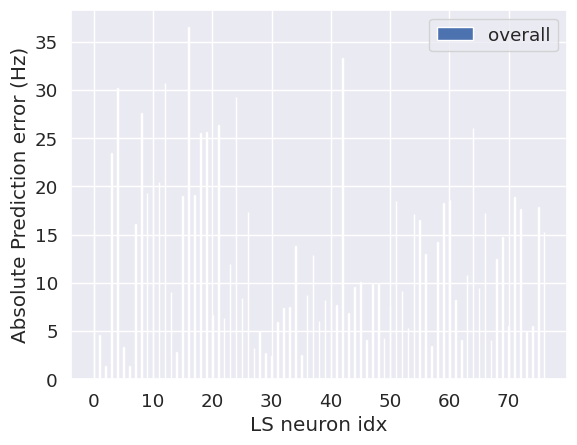

In [53]:
glm_LS_losses = np.load(save_path / 'AUG23-stim-LS-glm-losses.npy')
logger.info(f'Predicting mean for each of the LS neurons: {np.power(Y_test_LS_np - Y_test_LS_np.mean(0), 2).sum(0) / Y_test_LS_np.shape[0]}')

plt.figure()
plt.bar(np.arange(output_dim), np.sqrt(glm_LS_losses.mean(0)), width=0.1, label='overall')
# plt.bar(np.arange(8)-0.1, np.sqrt(glm_LS_losses[forward_mse_idx].mean(0)), width=0.1, label='forward')
# plt.bar(np.arange(8), np.sqrt(glm_LS_losses[backward_mse_idx].mean(0)), width=0.1, label='backward')
# plt.bar(np.arange(8)+0.1, np.sqrt(glm_LS_losses[random_mse_idx].mean(0)), width=0.1, label='random')
# plt.bar(np.arange(8)+0.2, np.sqrt(glm_LS_losses[non_stim_mse_idx].mean(0)), width=0.1, label='endogenous')
plt.xlabel('LS neuron idx')
plt.ylabel('Absolute Prediction error (Hz)')
plt.legend()
plt.show()